
=== Training Calibration RL Model ===
Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to logs/tensorboard/PPO_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -2.28e+04 |
| time/              |           |
|    fps             | 1409      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.57e+05   |
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017152948 |
|    clip_fraction        | 0.277       |
|    clip_range      

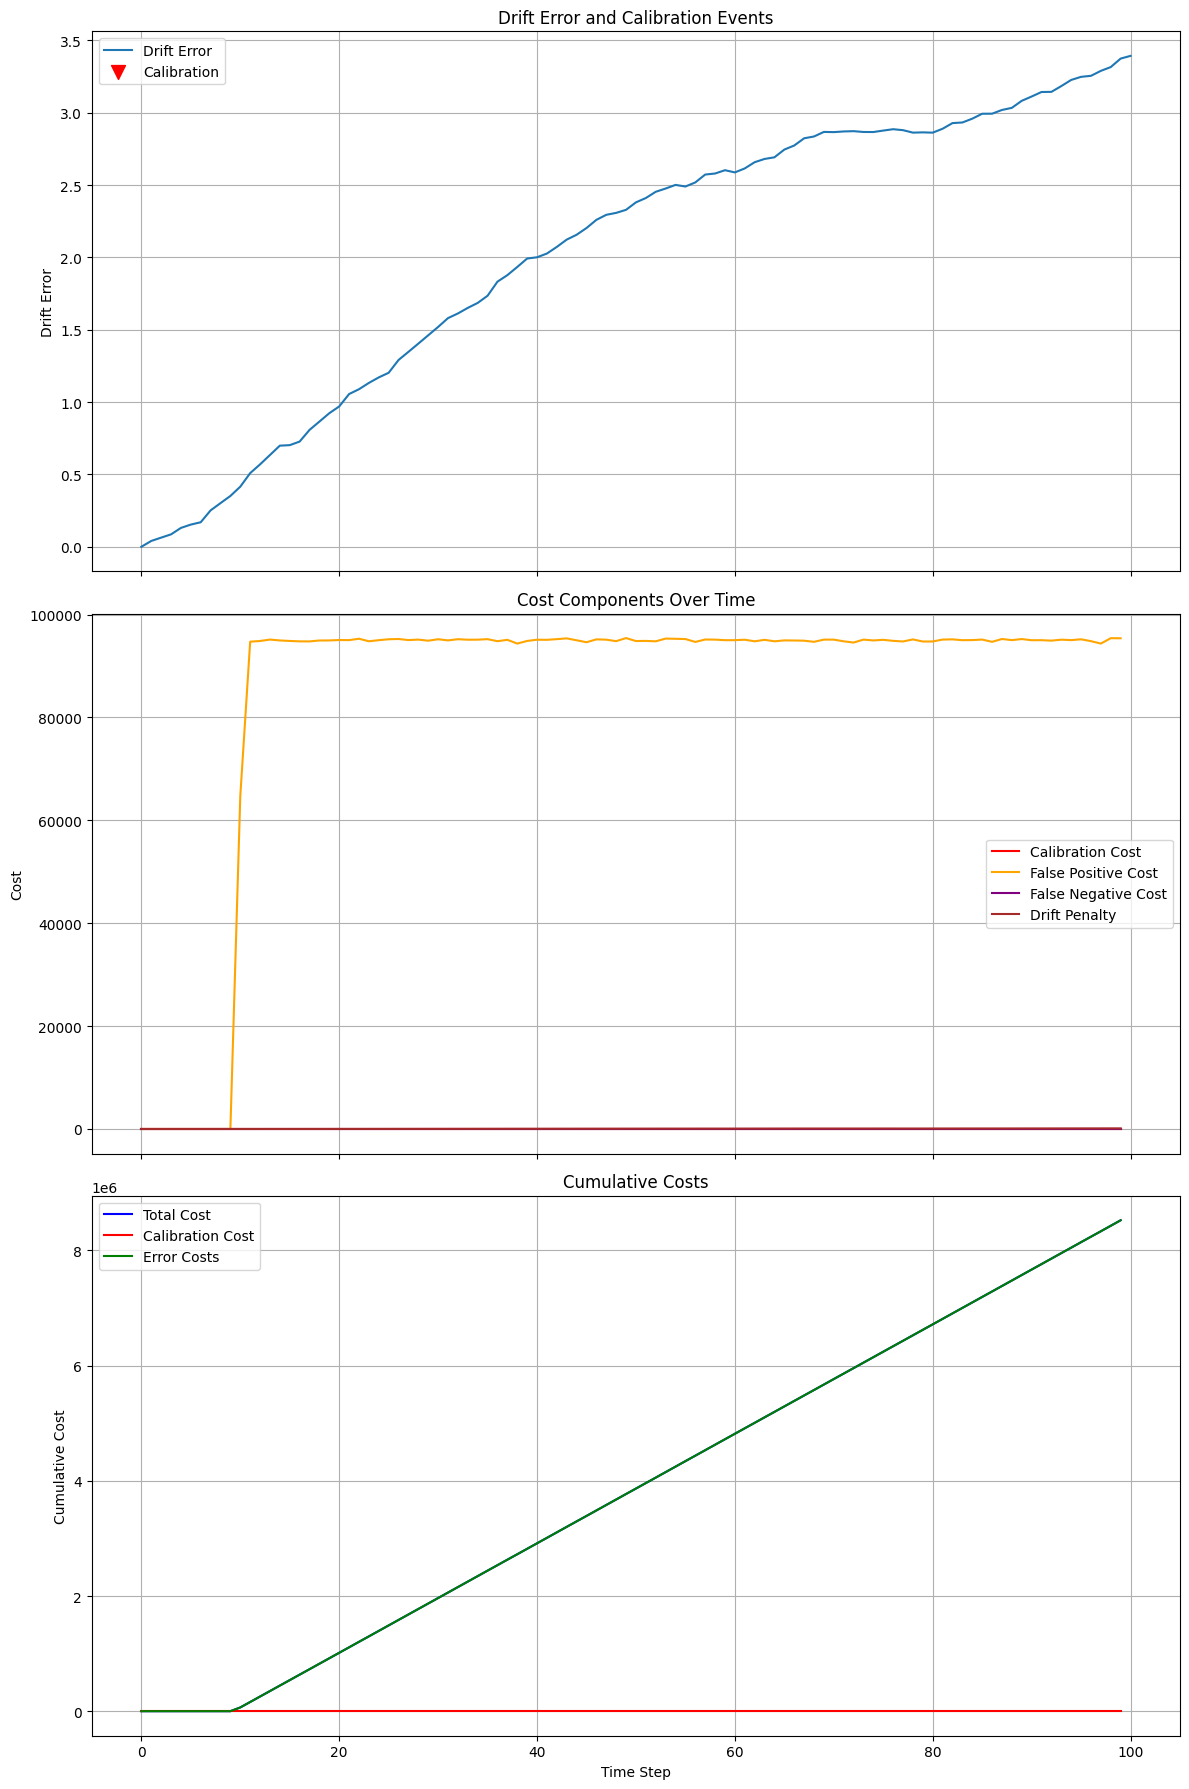

Episode Summary:
  Total reward: $8524728.49
  Number of calibrations: 0
  Cost breakdown:
    - Calibration costs: $0.00 (0.0%)
    - False positive costs: $8519510.00 (99.9%)
    - False negative costs: $0.00 (0.0%)
    - Drift penalty costs: $5218.49 (0.1%)


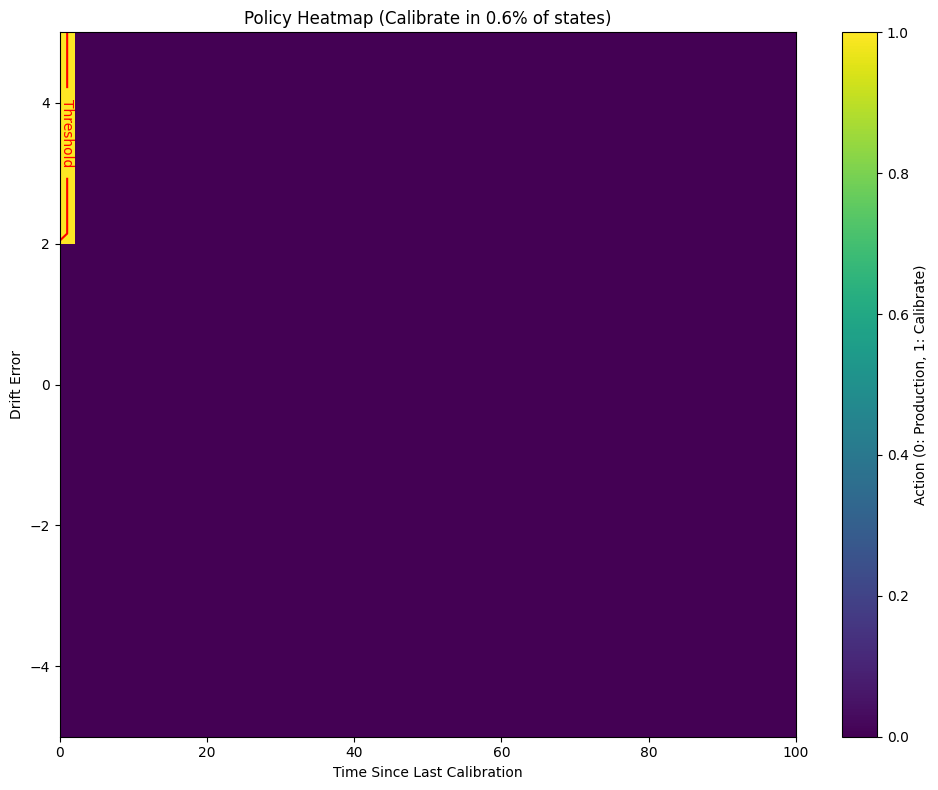


Average Metrics Over All Episodes:
  Average reward: $-8524015.60
  Average calibrations: 0.00
  Average calibration cost: $0.00
  Average FP cost: $8517190.00
  Average FN cost: $0.00

=== Comparing to Fixed-Interval Baselines ===


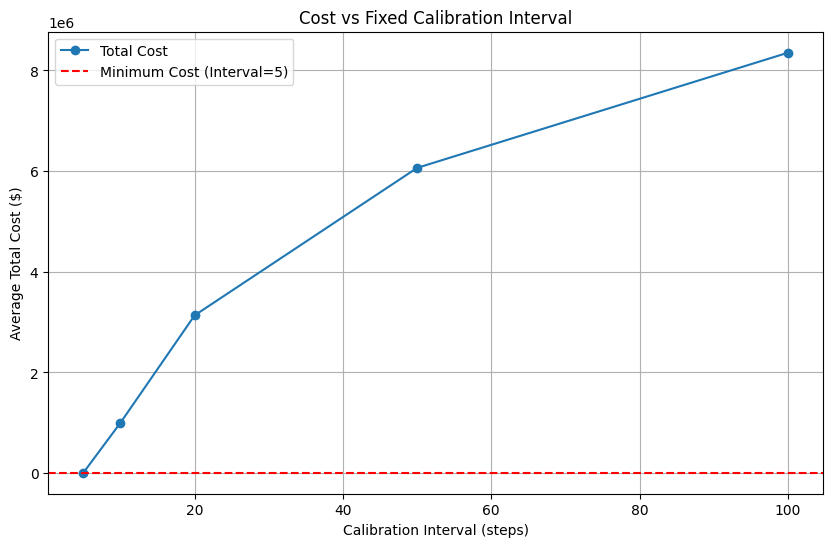


Fixed Interval Policy Results:
  Interval 5.0:
    - Average cost: $8583.33
    - Average calibrations: 20.00
  Interval 10.0:
    - Average cost: $1000876.67
    - Average calibrations: 10.00
  Interval 20.0:
    - Average cost: $3133980.00
    - Average calibrations: 5.00
  Interval 50.0:
    - Average cost: $6063566.67
    - Average calibrations: 2.00
  Interval 100.0:
    - Average cost: $8351066.67
    - Average calibrations: 1.00

Optimal fixed interval: 5 steps (Cost: $8583.33)
Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to logs/tensorboard/PPO_2
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -2.02e+04 |
| time/              |           |
|    fps             | 1391      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |    

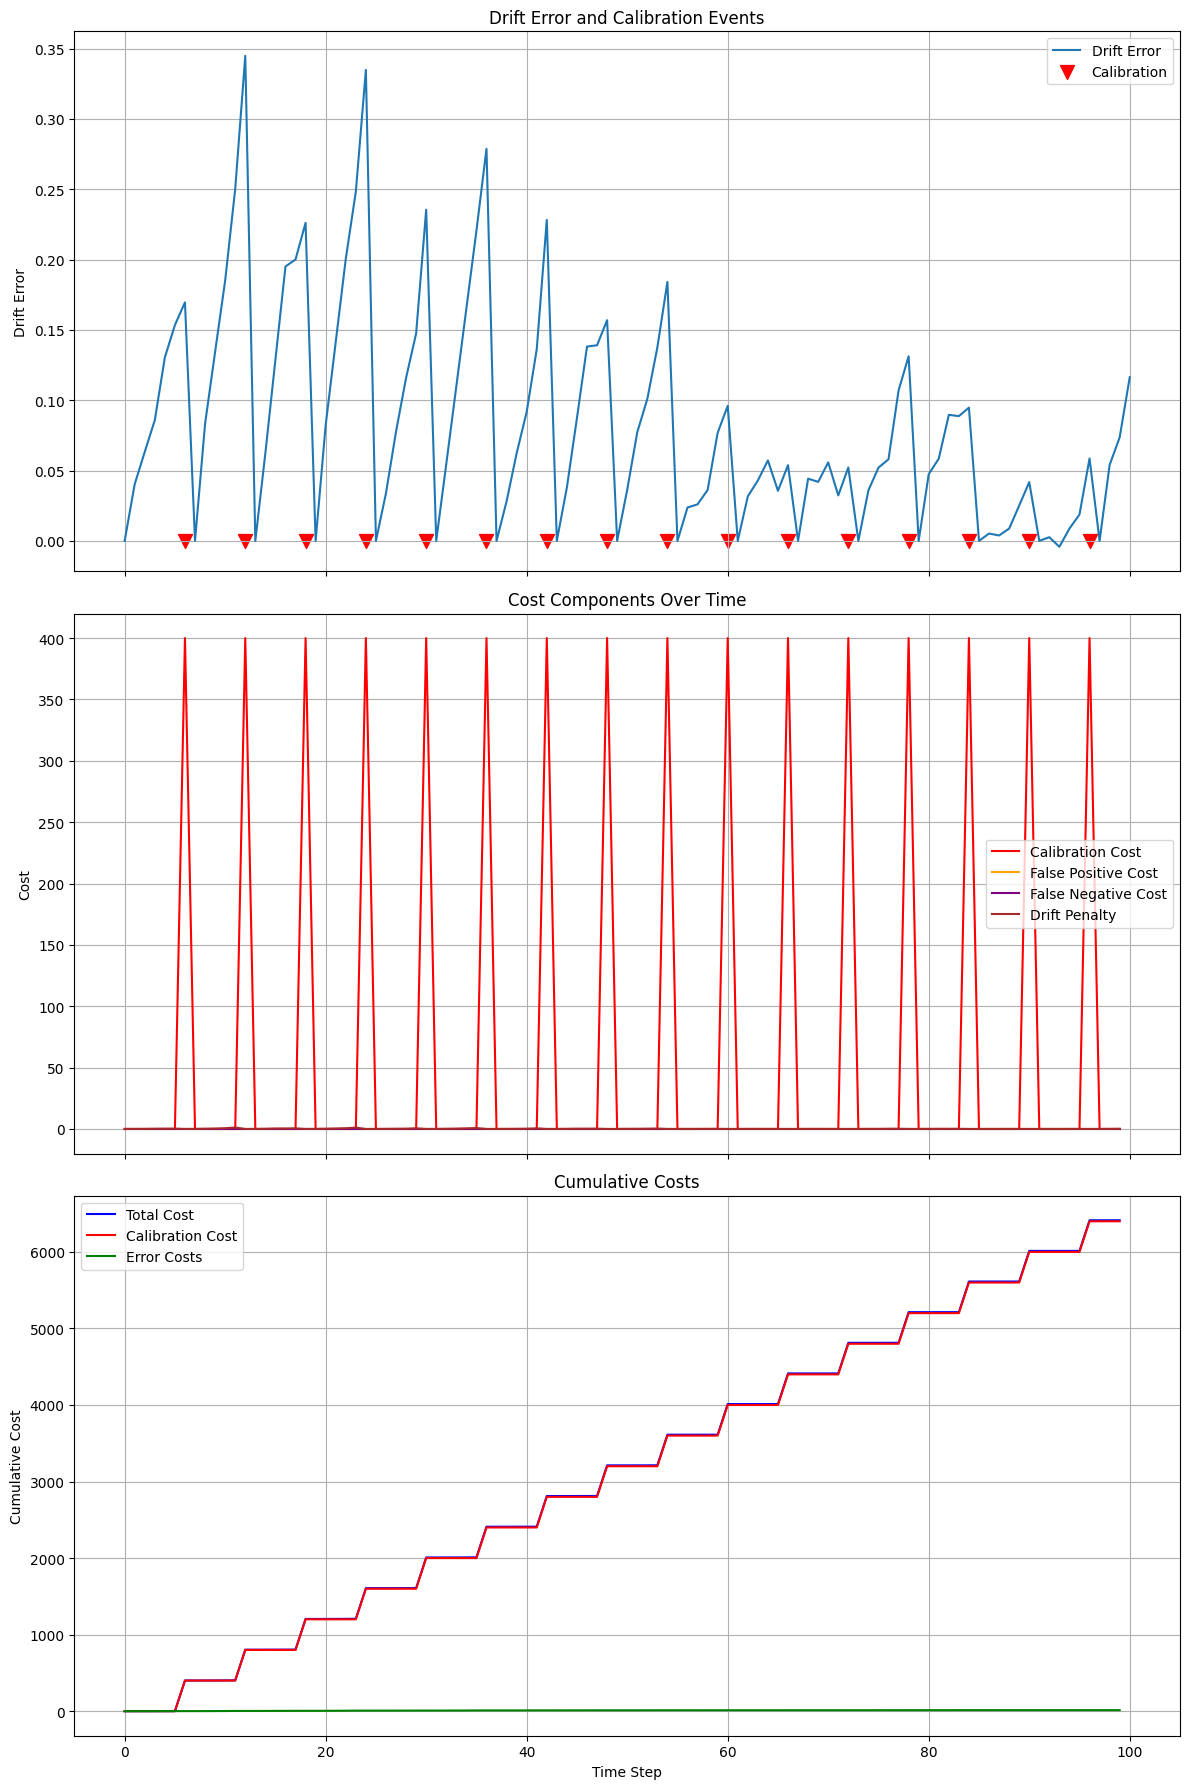

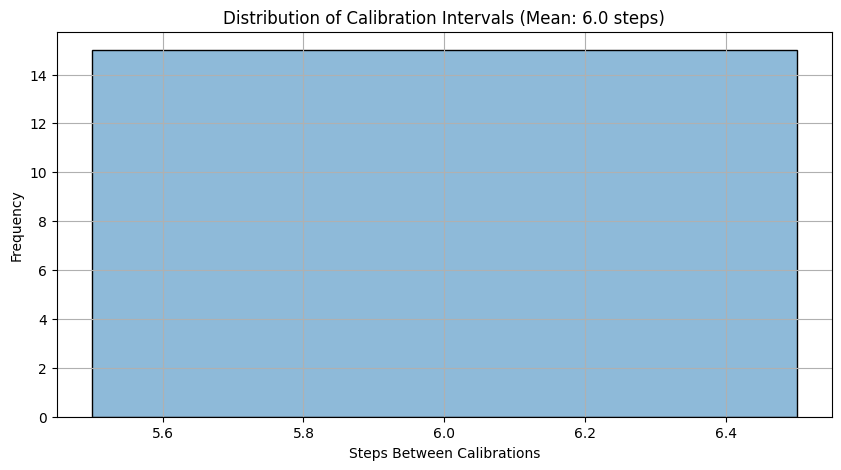

Episode Summary:
  Total reward: $6413.40
  Number of calibrations: 16
  Average calibration interval: 6.0 steps
  Cost breakdown:
    - Calibration costs: $6400.00 (99.8%)
    - False positive costs: $0.00 (0.0%)
    - False negative costs: $0.00 (0.0%)
    - Drift penalty costs: $13.40 (0.2%)


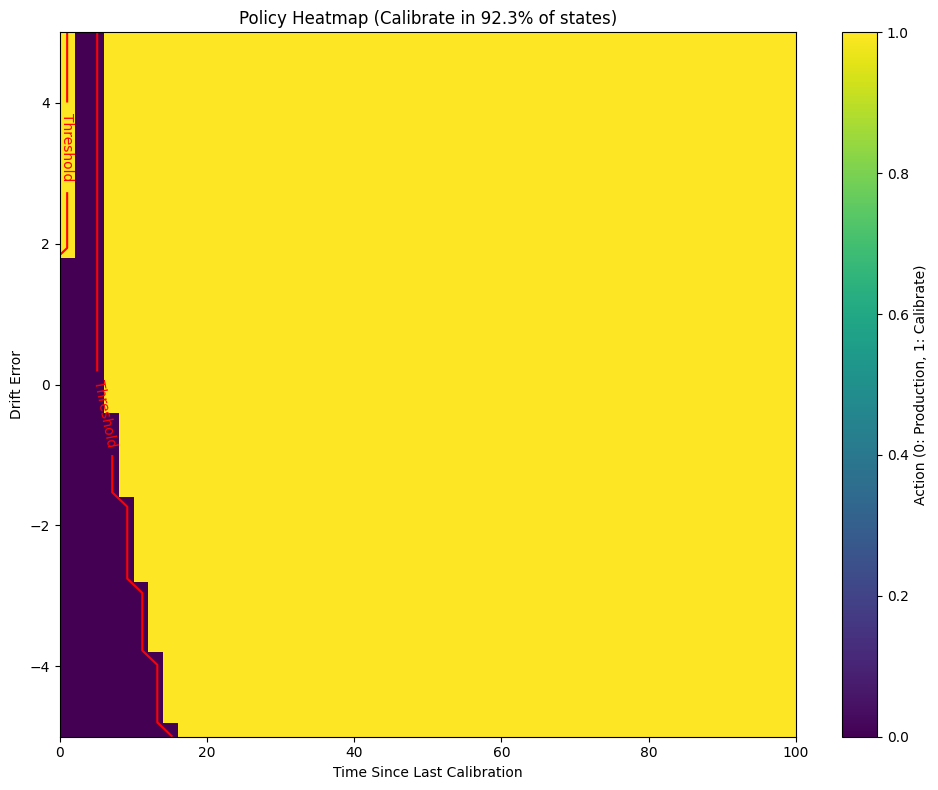


Average Metrics Over All Episodes:
  Average reward: $-6417.45
  Average calibrations: 16.00
  Average calibration cost: $6400.00
  Average FP cost: $0.00
  Average FN cost: $0.00

RL Policy Cost: $6400.00
Improvement over best fixed interval: $2183.33 (25.4%)

All done!


In [1]:
import gymnasium as gym
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, Any, Optional, List
from gymnasium import spaces
from dataclasses import dataclass

# -------------------------------
# Configuration Classes
# -------------------------------
@dataclass
class CalibrationConfig:
    """
    Configuration parameters for the calibration environment.
    Note: The time step is assumed to represent 1 month.
    """
    max_steps: int = 1000           # Maximum steps per episode
    drift_rate_mean: float = 0.05    # Mean drift rate per time step
    drift_rate_std: float = 0.01     # Standard deviation of drift rate variability
    noise_std: float = 0.02          # Measurement noise standard deviation
    threshold: float = 0.5           # Classification threshold
    batch_size: int = 100           # Products per time step (consider if 1000 is too high for your process)
    p_fault: float = 0.05            # Base probability of product fault

    # Cost parameters (in dollars)
    c_cal: float = 200             # Fixed calibration cost
    c_down: float = 100            # Downtime cost during calibration
    c_fp: float = 10              # Cost per false positive
    c_fn: float = 100             # Cost per false negative

    # Additional reward shaping parameter: penalty for drift accumulation
    drift_penalty_coeff: float = 10.0  # Coefficient for quadratic drift error penalty

    # Feature flags for additional dynamics
    use_seasonality: bool = True    # Whether to incorporate seasonal drift patterns
    seasonality_period: int = 100   # Period for seasonal component (in steps)
    seasonality_amplitude: float = 0.02  # Amplitude of seasonal component

# -------------------------------
# Custom Environment Definition
# -------------------------------
class CalibrationEnv(gym.Env):
    """
    Custom Gym environment for optimizing calibration frequency.
    
    At each time step (1 month), the environment simulates tool drift
    affecting product quality. Two actions are possible:
      - Action 0: Continue production (accumulating drift error)
      - Action 1: Calibrate tool (incurring calibration and downtime cost; production is paused)
    
    The state includes:
      - Drift error (which can be negative or positive)
      - Time since last calibration
      - Running average false positive (FP) rate
      - Running average false negative (FN) rate
      - Current drift rate estimate
    
    Reward is the negative total cost incurred plus a penalty for drift error.
    """
    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self, config: Optional[CalibrationConfig] = None):
        super(CalibrationEnv, self).__init__()
        self.config = config or CalibrationConfig()
        
        # Initialize state variables
        self.current_step = 0
        self.drift_error = 0.0
        self.last_calibration_step = 0
        self.drift_rate = 0.0  # Set in reset()
        self.fp_history = []  # Store false positive rates
        self.fn_history = []  # Store false negative rates
        self.seasonal_component = 0.0
        
        # Metrics for performance evaluation
        self.total_calibration_cost = 0.0
        self.total_fp_cost = 0.0
        self.total_fn_cost = 0.0
        self.total_calibrations = 0
        
        # Revised observation space:
        # Allow drift_error to be negative. The bounds here are heuristic.
        obs_low = np.array([-10.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        obs_high = np.array([10.0, self.config.max_steps, 1.0, 1.0, 1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)
        
        # Action space: 0 = continue production, 1 = calibrate
        self.action_space = spaces.Discrete(2)
        
        # For visualization and analysis
        self.state_history = []
        self.action_history = []
        self.reward_history = []
        self.cost_breakdown_history = []

    def _get_observation(self) -> np.ndarray:
        """
        Construct the current observation.
        Observation vector:
          [drift_error, time_since_calibration, running_fp_rate, running_fn_rate, drift_rate_estimate]
        """
        fp_rate = np.mean(self.fp_history[-10:]) if self.fp_history else 0.0
        fn_rate = np.mean(self.fn_history[-10:]) if self.fn_history else 0.0
        drift_rate_estimate = self.drift_rate if self.current_step > 10 else 0.0
        
        return np.array([
            self.drift_error,
            self.current_step - self.last_calibration_step,
            fp_rate,
            fn_rate,
            drift_rate_estimate
        ], dtype=np.float32)

    def _update_seasonal_component(self) -> None:
        """Update seasonal drift based on current step."""
        if self.config.use_seasonality:
            self.seasonal_component = self.config.seasonality_amplitude * np.sin(
                2 * np.pi * self.current_step / self.config.seasonality_period
            )
        else:
            self.seasonal_component = 0.0

    def _simulate_production(self) -> Tuple[int, int]:
        """
        Simulate production for one batch using vectorized operations.
        
        Returns:
            Tuple[int, int]: Number of false positives and false negatives.
        """
        # Vectorized simulation of batch production
        batch = self.config.batch_size
        
        # Ground truth: 1 indicates faulty, generated by comparing random numbers with p_fault
        ground_truth = (np.random.rand(batch) < self.config.p_fault).astype(int)
        
        # Generate noise for each product
        noise = np.random.normal(0, self.config.noise_std, batch)
        
        # Simulate measurements: ground truth + accumulated drift error + noise
        measurements = ground_truth + self.drift_error + noise
        
        # Prediction using threshold
        predictions = (measurements >= self.config.threshold).astype(int)
        
        # Calculate errors
        false_positives = int(np.sum((ground_truth == 0) & (predictions == 1)))
        false_negatives = int(np.sum((ground_truth == 1) & (predictions == 0)))
        
        return false_positives, false_negatives

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        """
        Execute one time step.
        
        Args:
            action: 0 (continue production) or 1 (calibrate)
            
        Returns:
            observation, reward, terminated, truncated, info
        """
        self.action_history.append(action)
        calibration_cost = 0.0
        fp_cost = 0.0
        fn_cost = 0.0
        
        if action == 1:  # Calibrate: no production, reset drift
            calibration_cost = self.config.c_cal + self.config.c_down
            self.drift_error = 0.0
            self.last_calibration_step = self.current_step
            self.total_calibrations += 1
            self.total_calibration_cost += calibration_cost
            fp, fn = 0, 0
        else:  # Continue production
            self._update_seasonal_component()
            # Update drift error: add drift, seasonal effect, and noise (from a single sample)
            self.drift_error += (self.drift_rate + self.seasonal_component + 
                                 np.random.normal(0, self.config.noise_std))
            fp, fn = self._simulate_production()
            fp_cost = fp * self.config.c_fp
            fn_cost = fn * self.config.c_fn
            self.total_fp_cost += fp_cost
            self.total_fn_cost += fn_cost
            # Update error rate histories (avoid division by zero)
            self.fp_history.append(fp / self.config.batch_size)
            self.fn_history.append(fn / max(1, int(self.config.p_fault * self.config.batch_size)))
        
        total_cost = calibration_cost + fp_cost + fn_cost
        
        # Add an immediate penalty for drift error accumulation (quadratic penalty)
        drift_penalty = self.config.drift_penalty_coeff * (self.drift_error ** 2)
        reward = - (total_cost + drift_penalty)
        
        self.cost_breakdown_history.append({
            'calibration': calibration_cost,
            'fp': fp_cost,
            'fn': fn_cost,
            'drift_penalty': drift_penalty,
            'total': total_cost + drift_penalty
        })
        
        self.current_step += 1
        obs = self._get_observation()
        self.state_history.append(obs)
        self.reward_history.append(reward)
        
        terminated = self.current_step >= self.config.max_steps
        truncated = False
        
        info = {
            'drift_error': self.drift_error,
            'time_since_calibration': self.current_step - self.last_calibration_step,
            'fp_count': fp,
            'fn_count': fn,
            'fp_cost': fp_cost,
            'fn_cost': fn_cost,
            'calibration_cost': calibration_cost,
            'drift_penalty': drift_penalty,
            'total_cost': total_cost + drift_penalty
        }
        return obs, reward, terminated, truncated, info

    def reset(self, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        """
        Reset the environment.
        """
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            
        self.current_step = 0
        self.drift_error = 0.0
        self.last_calibration_step = 0
        self.fp_history = []
        self.fn_history = []
        self.seasonal_component = 0.0
        
        self.total_calibration_cost = 0.0
        self.total_fp_cost = 0.0
        self.total_fn_cost = 0.0
        self.total_calibrations = 0
        
        self.state_history = []
        self.action_history = []
        self.reward_history = []
        self.cost_breakdown_history = []
        
        # Set a random drift rate for this episode based on configuration
        self.drift_rate = np.random.normal(self.config.drift_rate_mean, self.config.drift_rate_std)
        
        initial_obs = self._get_observation()
        self.state_history.append(initial_obs)
        return initial_obs, {}

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        if mode == 'human':
            print(f"Step: {self.current_step}, Drift Error: {self.drift_error:.3f}, "
                  f"Time Since Calibration: {self.current_step - self.last_calibration_step}")
            return None
        # rgb_array mode not implemented
        return None

    def get_episode_stats(self) -> Dict[str, Any]:
        return {
            'total_reward': sum(self.reward_history),
            'total_calibrations': self.total_calibrations,
            'total_calibration_cost': self.total_calibration_cost,
            'total_fp_cost': self.total_fp_cost,
            'total_fn_cost': self.total_fn_cost,
            'calibration_steps': [i for i, a in enumerate(self.action_history) if a == 1],
            'average_drift_error': np.mean([s[0] for s in self.state_history]),
        }

    def visualize_episode(self) -> None:
        stats = self.get_episode_stats()
        calibration_steps = stats['calibration_steps']
        
        state_df = pd.DataFrame(self.state_history, 
                                columns=['drift_error', 'time_since_cal', 'fp_rate', 'fn_rate', 'drift_est'])
        cost_df = pd.DataFrame(self.cost_breakdown_history)
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        axes[0].plot(state_df.index, state_df['drift_error'], label="Drift Error")
        axes[0].scatter(calibration_steps, [0] * len(calibration_steps), color='red', marker='v', s=100, label="Calibration")
        axes[0].set_ylabel("Drift Error")
        axes[0].set_title("Drift Error and Calibration Events")
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(cost_df.index, cost_df['calibration'], label="Calibration Cost", color='red')
        axes[1].plot(cost_df.index, cost_df['fp'], label="False Positive Cost", color='orange')
        axes[1].plot(cost_df.index, cost_df['fn'], label="False Negative Cost", color='purple')
        axes[1].plot(cost_df.index, cost_df['drift_penalty'], label="Drift Penalty", color='brown')
        axes[1].set_ylabel("Cost")
        axes[1].set_title("Cost Components Over Time")
        axes[1].legend()
        axes[1].grid(True)
        
        cumulative_costs = cost_df.cumsum()
        axes[2].plot(cumulative_costs.index, cumulative_costs['total'], label="Total Cost", color='blue')
        axes[2].plot(cumulative_costs.index, cumulative_costs['calibration'], label="Calibration Cost", color='red')
        axes[2].plot(cumulative_costs.index, cumulative_costs['fp'] + cumulative_costs['fn'] + cumulative_costs['drift_penalty'], label="Error Costs", color='green')
        axes[2].set_xlabel("Time Step")
        axes[2].set_ylabel("Cumulative Cost")
        axes[2].set_title("Cumulative Costs")
        axes[2].legend()
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        if len(calibration_steps) > 1:
            intervals = np.diff(calibration_steps)
            plt.figure(figsize=(10, 5))
            sns.histplot(intervals, kde=True)
            plt.title(f"Distribution of Calibration Intervals (Mean: {np.mean(intervals):.1f} steps)")
            plt.xlabel("Steps Between Calibrations")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
        
        print("Episode Summary:")
        print(f"  Total reward: ${-sum(self.reward_history):.2f}")
        print(f"  Number of calibrations: {self.total_calibrations}")
        if len(calibration_steps) > 1:
            print(f"  Average calibration interval: {np.mean(np.diff(calibration_steps)):.1f} steps")
        total_episode_cost = sum(cost_df['total'])
        if total_episode_cost > 0:
            print("  Cost breakdown:")
            print(f"    - Calibration costs: ${self.total_calibration_cost:.2f} ({self.total_calibration_cost/total_episode_cost*100:.1f}%)")
            print(f"    - False positive costs: ${self.total_fp_cost:.2f} ({self.total_fp_cost/total_episode_cost*100:.1f}%)")
            print(f"    - False negative costs: ${self.total_fn_cost:.2f} ({self.total_fn_cost/total_episode_cost*100:.1f}%)")
            print(f"    - Drift penalty costs: ${np.sum(cost_df['drift_penalty']):.2f} ({np.sum(cost_df['drift_penalty'])/total_episode_cost*100:.1f}%)")

# -------------------------------
# Policy Analysis Utilities
# -------------------------------
class PolicyAnalyzer:
    """Analysis tools for RL calibration policies."""
    
    @staticmethod
    def create_policy_heatmap(model, env, title="Policy Heatmap"):
        drift_vals = np.linspace(-5, 5, 50)
        time_vals = np.linspace(0, env.config.max_steps, 50)
        action_map = np.zeros((len(drift_vals), len(time_vals)))
        
        # Fixed values for additional state features
        fp_rate = 0.05
        fn_rate = 0.05
        drift_rate_est = env.config.drift_rate_mean
        
        for i, drift in enumerate(drift_vals):
            for j, time in enumerate(time_vals):
                obs = np.array([drift, time, fp_rate, fn_rate, drift_rate_est], dtype=np.float32)
                action, _ = model.predict(obs, deterministic=True)
                action_map[i, j] = action
        
        plt.figure(figsize=(10, 8))
        plt.imshow(action_map, aspect='auto', origin='lower',
                   extent=[time_vals[0], time_vals[-1], drift_vals[0], drift_vals[-1]])
        calibrate_pct = np.mean(action_map) * 100
        plt.colorbar(label="Action (0: Production, 1: Calibrate)")
        plt.xlabel("Time Since Last Calibration")
        plt.ylabel("Drift Error")
        plt.title(f"{title} (Calibrate in {calibrate_pct:.1f}% of states)")
        try:
            cs = plt.contour(time_vals, drift_vals, action_map, levels=[0.5], colors='red')
            plt.clabel(cs, inline=1, fontsize=10, fmt='Threshold')
        except Exception:
            pass
        plt.tight_layout()
        plt.show()

    @staticmethod
    def analyze_policy_sensitivity(model, env, param_name, values, runs_per_value=5):
        results = []
        for value in values:
            config = CalibrationConfig()
            setattr(config, param_name, value)
            test_env = CalibrationEnv(config)
            value_results = []
            for run in range(runs_per_value):
                obs, _ = test_env.reset(seed=42+run)
                done = False
                while not done:
                    action, _ = model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, _ = test_env.step(action)
                    done = terminated or truncated
                stats = test_env.get_episode_stats()
                value_results.append({
                    'total_reward': stats['total_reward'],
                    'calibrations': stats['total_calibrations'],
                    'total_cost': stats['total_calibration_cost'] + stats['total_fp_cost'] + stats['total_fn_cost']
                })
            avg_results = {
                'value': value,
                'avg_reward': np.mean([r['total_reward'] for r in value_results]),
                'avg_calibrations': np.mean([r['calibrations'] for r in value_results]),
                'avg_cost': np.mean([r['total_cost'] for r in value_results])
            }
            results.append(avg_results)
        
        results_df = pd.DataFrame(results)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.plot(results_df['value'], -results_df['avg_reward'], marker='o', label='Total Cost')
        ax1.set_xlabel(param_name)
        ax1.set_ylabel('Average Total Cost')
        ax1.grid(True)
        ax1.set_title(f'Cost vs {param_name}')
        ax2.plot(results_df['value'], results_df['avg_calibrations'], marker='o', color='red')
        ax2.set_xlabel(param_name)
        ax2.set_ylabel('Average Number of Calibrations')
        ax2.grid(True)
        ax2.set_title(f'Calibration Frequency vs {param_name}')
        plt.tight_layout()
        plt.show()
        return results_df

# -------------------------------
# Training and Evaluation Code
# -------------------------------
def train_calibration_model(config: Optional[CalibrationConfig] = None,
                            total_timesteps: int = 100000,
                            algorithm: str = "PPO") -> Tuple[Any, str]:
    from stable_baselines3 import PPO, A2C, DQN
    from stable_baselines3.common.env_checker import check_env
    from stable_baselines3.common.callbacks import EvalCallback
    from stable_baselines3.common.monitor import Monitor
    
    env_config = config or CalibrationConfig()
    env = CalibrationEnv(env_config)
    check_env(env, warn=True)
    os.makedirs("logs", exist_ok=True)
    os.makedirs("models", exist_ok=True)
    env = Monitor(env, "logs/")
    eval_env = CalibrationEnv(env_config)
    eval_env = Monitor(eval_env, "logs/eval/")
    eval_callback = EvalCallback(eval_env, best_model_save_path="models/",
                                 log_path="logs/", eval_freq=5000,
                                 deterministic=True, render=False)
    
    if algorithm == "PPO":
        model = PPO("MlpPolicy", env, verbose=1, gamma=0.9, tensorboard_log="logs/tensorboard/")
    elif algorithm == "A2C":
        model = A2C("MlpPolicy", env, verbose=1, gamma=0.9, tensorboard_log="logs/tensorboard/")
    elif algorithm == "DQN":
        model = DQN("MlpPolicy", env, verbose=1, gamma=0.9, tensorboard_log="logs/tensorboard/")
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")
    
    model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    model_path = f"models/final_{algorithm}_model"
    model.save(model_path)
    print(f"Training completed. Model saved to {model_path}")
    return model, model_path

def evaluate_model(model, config: Optional[CalibrationConfig] = None, episodes: int = 5) -> pd.DataFrame:
    env_config = config or CalibrationConfig()
    eval_env = CalibrationEnv(env_config)
    all_stats = []
    for ep in range(episodes):
        obs, _ = eval_env.reset(seed=1000 + ep)
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
        stats = eval_env.get_episode_stats()
        stats['episode'] = ep + 1
        all_stats.append(stats)
        if ep == 0:
            eval_env.visualize_episode()
            PolicyAnalyzer.create_policy_heatmap(model, eval_env)
    stats_df = pd.DataFrame(all_stats)
    print("\nAverage Metrics Over All Episodes:")
    print(f"  Average reward: ${stats_df['total_reward'].mean():.2f}")
    print(f"  Average calibrations: {stats_df['total_calibrations'].mean():.2f}")
    print(f"  Average calibration cost: ${stats_df['total_calibration_cost'].mean():.2f}")
    print(f"  Average FP cost: ${stats_df['total_fp_cost'].mean():.2f}")
    print(f"  Average FN cost: ${stats_df['total_fn_cost'].mean():.2f}")
    return stats_df

def compare_algorithms(config: Optional[CalibrationConfig] = None,
                       total_timesteps: int = 50000,
                       eval_episodes: int = 3) -> None:
    algorithms = ["PPO", "A2C", "DQN"]
    results = {}
    for alg in algorithms:
        print(f"\n{'='*40}\nTraining {alg}...\n{'='*40}\n")
        model, _ = train_calibration_model(config=config, total_timesteps=total_timesteps, algorithm=alg)
        print(f"\n{'-'*40}\nEvaluating {alg}...\n{'-'*40}\n")
        stats = evaluate_model(model, config, episodes=eval_episodes)
        results[alg] = stats
    comparison = {alg: {
        'avg_reward': results[alg]['total_reward'].mean(),
        'avg_calibrations': results[alg]['total_calibrations'].mean(),
        'avg_total_cost': (results[alg]['total_calibration_cost'] + results[alg]['total_fp_cost'] + results[alg]['total_fn_cost']).mean()
    } for alg in algorithms}
    algs = list(comparison.keys())
    costs = [comparison[alg]['avg_total_cost'] for alg in algs]
    calibrations = [comparison[alg]['avg_calibrations'] for alg in algs]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.bar(algs, costs, color=['blue', 'green', 'orange'])
    ax1.set_ylabel('Average Total Cost ($)')
    ax1.set_title('Cost Comparison by Algorithm')
    ax1.grid(axis='y')
    ax2.bar(algs, calibrations, color=['red', 'purple', 'brown'])
    ax2.set_ylabel('Average Number of Calibrations')
    ax2.set_title('Calibration Frequency by Algorithm')
    ax2.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\nAlgorithm Comparison:")
    for alg in algs:
        print(f"  {alg}:")
        print(f"    - Average total cost: ${comparison[alg]['avg_total_cost']:.2f}")
        print(f"    - Average calibrations: {comparison[alg]['avg_calibrations']:.2f}")

def sensitivity_analysis(model, base_config: Optional[CalibrationConfig] = None) -> None:
    env_config = base_config or CalibrationConfig()
    analyzer = PolicyAnalyzer()
    print("\nAnalyzing sensitivity to drift rate...")
    drift_rates = np.linspace(0.02, 0.1, 5)
    analyzer.analyze_policy_sensitivity(model, CalibrationEnv(env_config), 'drift_rate_mean', drift_rates)
    print("\nAnalyzing sensitivity to false negative cost...")
    fn_costs = np.linspace(50, 200, 5)
    analyzer.analyze_policy_sensitivity(model, CalibrationEnv(env_config), 'c_fn', fn_costs)
    print("\nAnalyzing sensitivity to calibration cost...")
    cal_costs = np.linspace(100, 400, 5)
    analyzer.analyze_policy_sensitivity(model, CalibrationEnv(env_config), 'c_cal', cal_costs)
    for drift_rate in [0.02, 0.05, 0.1]:
        test_config = CalibrationConfig()
        test_config.drift_rate_mean = drift_rate
        test_env = CalibrationEnv(test_config)
        analyzer.create_policy_heatmap(model, test_env, title=f"Policy Heatmap (Drift Rate = {drift_rate})")

def run_baseline_comparison(config: Optional[CalibrationConfig] = None, episodes: int = 5) -> None:
    env_config = config or CalibrationConfig()
    env = CalibrationEnv(env_config)
    intervals = [5, 10, 20, 50, 100]
    results = []
    for interval in intervals:
        interval_results = []
        for ep in range(episodes):
            obs, _ = env.reset(seed=2000 + ep)
            done = False
            step_count = 0
            while not done:
                action = 1 if step_count % interval == 0 else 0
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                step_count += 1
            stats = env.get_episode_stats()
            stats['interval'] = interval
            stats['episode'] = ep + 1
            interval_results.append(stats)
        avg_stats = {
            'interval': interval,
            'avg_reward': np.mean([r['total_reward'] for r in interval_results]),
            'avg_calibrations': np.mean([r['total_calibrations'] for r in interval_results]),
            'avg_total_cost': np.mean([r['total_calibration_cost'] + r['total_fp_cost'] + r['total_fn_cost'] for r in interval_results])
        }
        results.append(avg_stats)
    baseline_df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    plt.plot(baseline_df['interval'], baseline_df['avg_total_cost'], marker='o', linestyle='-', label='Total Cost')
    min_idx = baseline_df['avg_total_cost'].idxmin()
    plt.axhline(y=baseline_df.loc[min_idx, 'avg_total_cost'], color='r', linestyle='--',
                label=f"Minimum Cost (Interval={baseline_df.loc[min_idx, 'interval']})")
    plt.xlabel('Calibration Interval (steps)')
    plt.ylabel('Average Total Cost ($)')
    plt.title('Cost vs Fixed Calibration Interval')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("\nFixed Interval Policy Results:")
    for _, row in baseline_df.iterrows():
        print(f"  Interval {row['interval']}:")
        print(f"    - Average cost: ${row['avg_total_cost']:.2f}")
        print(f"    - Average calibrations: {row['avg_calibrations']:.2f}")
    
    best_interval = baseline_df.loc[min_idx, 'interval']
    best_cost = baseline_df.loc[min_idx, 'avg_total_cost']
    print(f"\nOptimal fixed interval: {best_interval} steps (Cost: ${best_cost:.2f})")
    
    from stable_baselines3 import PPO
    model, _ = train_calibration_model(config=env_config, total_timesteps=50000)
    rl_stats = evaluate_model(model, config=env_config, episodes=episodes)
    rl_cost = (rl_stats['total_calibration_cost'] + rl_stats['total_fp_cost'] + rl_stats['total_fn_cost']).mean()
    print(f"\nRL Policy Cost: ${rl_cost:.2f}")
    improvement = best_cost - rl_cost
    print(f"Improvement over best fixed interval: ${improvement:.2f} ({improvement / best_cost * 100:.1f}%)")

# -------------------------------
# Main Execution Block
# -------------------------------
if __name__ == '__main__':
    from stable_baselines3 import PPO
    
    # Configure environment parameters. Validate these with domain data.
    config = CalibrationConfig(
        max_steps=100,
        drift_rate_mean=0.05,
        drift_rate_std=0.02,
        noise_std=0.02,
        threshold=0.5,
        batch_size=10000,
        p_fault=0.05,
        c_cal=200,
        c_down=200,
        c_fp=10,
        c_fn=100,
        drift_penalty_coeff=10.0,
        use_seasonality=True,
        seasonality_period=100,
        seasonality_amplitude=0.02
    )
    
    # Toggle different execution modes
    RUN_TRAINING = True
    RUN_EVALUATION = True
    RUN_ALGORITHM_COMPARISON = False
    RUN_SENSITIVITY_ANALYSIS = False
    RUN_BASELINE_COMPARISON = True
    
    if RUN_TRAINING:
        print("\n=== Training Calibration RL Model ===")
        model, model_path = train_calibration_model(config=config, total_timesteps=50000, algorithm="PPO")
    else:
        model_path = "models/final_PPO_model"
        model = PPO.load(model_path)
    
    if RUN_EVALUATION:
        print("\n=== Evaluating Trained Model ===")
        stats = evaluate_model(model, config=config, episodes=3)
    
    if RUN_ALGORITHM_COMPARISON:
        print("\n=== Comparing RL Algorithms ===")
        compare_algorithms(config=config, total_timesteps=30000, eval_episodes=2)
    
    if RUN_SENSITIVITY_ANALYSIS:
        print("\n=== Performing Sensitivity Analysis ===")
        sensitivity_analysis(model, config)
    
    if RUN_BASELINE_COMPARISON:
        print("\n=== Comparing to Fixed-Interval Baselines ===")
        run_baseline_comparison(config=config, episodes=3)
    
    print("\nAll done!")
